James Cole  
Final project for EPPS 6317   
# LIDAR Scanner Control and Data Visualization in Python

**Version 1**  

This program will collect LIDAR measurements and servo positions from Arduino microcontrollers conencted to serial ports and create an interactive point cloud visualization using PyVista. Users can either run a scan or import data from a CSV file.   

Out-of-the box data collection requires a [Slamtec RPLIDAR A1](https://www.adafruit.com/product/4010) module attached to a tilt mount, but data can be imported form prior scans by skipping to Step 2b below after importing packages (Step 1). 

## 1. Import packages and get serial port info

### Import packages

In [4]:
import re
import pandas as pd
from rplidar import RPLidar
import serial
import serial.tools.list_ports
import math
import matplotlib.pyplot as plt
from pathlib import Path 
import os
import numpy as np
import pyvista as pv
from pyvistaqt import BackgroundPlotter

### Get serial port info
Use pyserial to list serial port details. These will be used to listen for data printed to the serial monitor.

In [3]:
# Show ports
ports = list(serial.tools.list_ports.comports())
for item in ports:
    print( item.name )
    print( item.description )
    print( item.hwid )
    print( item.vid )
    print( item.pid )
    print( item.serial_number )
    print( item.location )
    print( item.manufacturer )
    print( item.product )
    print( item.interface )

cu.Bluetooth-Incoming-Port
n/a
n/a
None
None
None
None
None
None
None


## 2a. Run scan 
Collect data from two serial ports. Only works with device attached.     
Skip if importing data.

In [2]:
# Declare ports
PORT_1 = '/dev/cu.usbserial-0001'  # Lidar
PORT_2 = serial.Serial('/dev/cu.usbserial-110', 1200)  # Servos

In [4]:
# Funcitons for starting and stopping lidar module
lidar = RPLidar(PORT_1)
def startLidar():
    print('Scanning...')
    lidar.start_motor()

def stopLidar():
    print('Stoping...')
    lidar.stop_motor()
    print('Stopped.')
        
data = []
def run_scan():
    
    for measurment in lidar.iter_measures():
        row = []
        line = '\t'.join(str(v) for v in measurment)
        cc = str(PORT_2.readline())
    
        row.append(line)
        row.append(cc) 
        # print(row)
        # data.append(row)

        if re.search("000", cc):
            break
        else:
            data.append(row)
            print(row)

# Run scan
startLidar()
run_scan()

## 2b. Import data
Skip if collecting data.

In [4]:
# # Import data
data = pd.read_csv('./data-exports/raw-sensor-data-office.csv')
data

,0,1
0,False\t15\t105.703125\t0.0,b'0\r\n'
1,False\t15\t107.0\t1372.75,b'0\r\n'
2,False\t15\t108.34375\t1389.0,b'0\r\n'
3,False\t15\t109.671875\t1403.75,b'0\r\n'
4,False\t15\t110.984375\t1420.75,b'0\r\n'
...,...,...
1271,False\t15\t7.171875\t0.0,b'178\r\n'
1272,False\t15\t8.5\t2781.0,b'178\r\n'
1273,False\t15\t9.78125\t0.0,b'178\r\n'
1274,False\t15\t11.140625\t0.0,b'178\r\n'


### Convert Cartesian coordinates to spherical coordinates

r = radius   
θ (theta) = inclination (pitch angle)  
φ (phi) = azimuth (yaw angle)

x = rsinθ cosφ  
y = rsinθ sinφ   
z = rcosθ

In [7]:
# Get spherical coordinates
def make_spherical(xpos, ypos, distance):
    # Variables
    # xpos = servo yaw angle between 0 and 180
    # ypos = lidar pitch angle between 0 and 360
    # distance = lidar distance reading
    pi = math.pi

    theta = float((xpos * pi) / 180)  # pan servo
    phi = float((ypos * pi) / 180)  # tilt servo

    z = distance * math.cos(phi)
    x = z * math.cos(phi) * math.cos(theta)
    y = z * math.cos(phi) * math.sin(theta)
    
    return [x, y, z]

# Make df from data
df = pd.DataFrame(data)
df = df.drop([0])

for index, row in df.iterrows():
    if re.search("^b", row[0]):
        move = row[0]
        row[0] = row[1]
        row[1] = move

last_row = len(df)
df = df.drop([last_row])
df

# Get angle and distance
new_data = []
tilt = df[1]  # change index to "1" (str) if importing data 

for index, row in df.iterrows():
    # print(row[0], row[1])
    new_row = []

    measurement = re.split("\t", row[0])

    distance = float(measurement[3])
    new_row.append(distance)

    angle = float(measurement[2])
    new_row.append(angle)
    
    tilt = re.search("\d{1,3}", row[1])
    if tilt:
        number = float(tilt.group(0))
        new_row.append(number)
    
    spherical_data = make_spherical(new_row[0], new_row[1], new_row[2])
    new_row = spherical_data

    new_data.append(new_row)

    # new_row = make_spherical(angle, tilt, distance)
    # newdata.append(make_spherical(angle, tilt, distance))

point_cloud_data = pd.DataFrame(new_data)
point_cloud_data = point_cloud_data.rename(columns={0: "x", 1: "y", 2: "z"})
point_cloud_data

# Convert data for PyVista
points = point_cloud_data.to_numpy()
points

# Create point cloud
point_cloud = pv.PolyData(points)

,0,1
1,False\t15\t107.0\t1372.75,b'0\r\n'
2,False\t15\t108.34375\t1389.0,b'0\r\n'
3,False\t15\t109.671875\t1403.75,b'0\r\n'
4,False\t15\t110.984375\t1420.75,b'0\r\n'
5,False\t15\t112.28125\t1437.5,b'0\r\n'
...,...,...
1270,False\t15\t5.84375\t2661.75,b'178\r\n'
1271,False\t15\t7.171875\t0.0,b'178\r\n'
1272,False\t15\t8.5\t2781.0,b'178\r\n'
1273,False\t15\t9.78125\t0.0,b'178\r\n'


### Export data  
Skip if not exporting data. 

Uncomment and run if exporting data.

In [47]:
# # Handle directory
# os.makedirs('./data-exports', exist_ok=True) 

# # Export raw sensor data
# df.to_csv('./data-exports/raw-sensor-data.csv', index=False)  

# # Export spherical data
# point_cloud_data.to_csv('./data-exports/spherical-data.csv', index=False)  

## 3. Create PyVista plots

#### Basic plot
Render a point cloud plot in the notebook.

/Users/jamescole/anaconda3/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


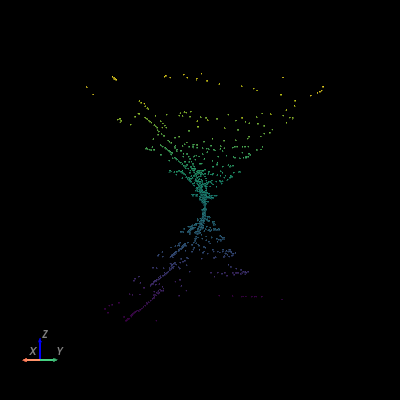

In [11]:
# Set plot theme styles
pv.global_theme.background = 'black'
pv.global_theme.font.color = 'grey'

# Basic plot
pl = pv.Plotter()
pl.add_mesh(point_cloud, 
            render_points_as_spheres = True,
            scalars = points[:, 2],
            point_size = 2,
            show_scalar_bar = False,
            )
camera = pv.Camera()
pl.camera = camera
pl.camera_position = 'yz'
pl.window_size = [400, 400]
pl.camera.azimuth = 45
pl.add_axes()
pl.show()


#### Interactive 3D plot
Render point cloud in new window. User can navigate around the point cloud. 

In [17]:
rgba = points - points.min(axis=0)
rgba /= rgba.max(axis=0)
# pv.plot(points, scalars=rgba, render_points_as_spheres=True, point_size=10, cpos='xy', rgba=True)

plotter = BackgroundPlotter()
plotter.add_mesh(point_cloud, scalars=rgba, rgba=True, point_size=3)

# plotter.add_floor()
# plotter.add_axes()

Actor (0x15fd6e200)
  Center:                     (10.27605553879458, 0.03346775364668986, 11.469525816649934)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -1.574E+02, 1.780E+02
  Y Bounds                    -1.720E+02, 1.720E+02
  Z Bounds                    -1.551E+02, 1.780E+02
  User matrix:                Unset
  Has mapper:                 True

Property (0x15fdeebc0)
  Ambient:                     0.0
  Ambient color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='lightblue', hex='#add8e6ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=25